In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/melanoma
/kaggle/input/melanoma/dermmel
/kaggle/input/melanoma/dermmel/DermMel
/kaggle/input/melanoma/dermmel/DermMel/valid
/kaggle/input/melanoma/dermmel/DermMel/valid/NotMelanoma
/kaggle/input/melanoma/dermmel/DermMel/valid/Melanoma
/kaggle/input/melanoma/dermmel/DermMel/train_sep
/kaggle/input/melanoma/dermmel/DermMel/train_sep/NotMelanoma
/kaggle/input/melanoma/dermmel/DermMel/train_sep/Melanoma
/kaggle/input/melanoma/dermmel/DermMel/test
/kaggle/input/melanoma/dermmel/DermMel/test/NotMelanoma
/kaggle/input/melanoma/dermmel/DermMel/test/Melanoma
/kaggle/input/melanoma/DermMel
/kaggle/input/melanoma/DermMel/valid
/kaggle/input/melanoma/DermMel/valid/NotMelanoma
/kaggle/input/melanoma/DermMel/valid/Melanoma
/kaggle/input/melanoma/DermMel/train_sep
/kaggle/input/melanoma/DermMel/train_sep/NotMelanoma
/kaggle/input/melanoma/DermMel/train_sep/Melanoma
/kaggle/input/melanoma/DermMel/test
/kaggle/input/melanoma/DermMel/test/NotMelanoma
/kaggle/input/melanoma/De

In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications import InceptionV3
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_training_curves(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)


    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'bo', label='Training loss', color="r", linestyle = ":")
    plt.plot(epochs, val_loss, 'b', label='Validation loss', color="g" )
    
    plt.legend()
    plt.figure()
    
    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'bo', label='Training acc', color="b", linestyle = ":")
    plt.plot(epochs, val_acc, 'b', label='Validation acc', color="g")
    
    plt.legend()
    plt.figure()
    
    plt.show()

def print_evaluation(loss_value, accuracy_value):
    print ('Loss value: ', loss_value)
    print ('Accuracy value: ', accuracy_value)

    
def print_results(cm):
    tp = cm[0][0] 
    tn = cm[1][1]
    fn = cm[0][1]
    fp = cm[1][0]
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = ((2*precision*recall) / (recall+precision)) * 100
    print("Accuracy: %f \n Sensitivity : %f \n Specificity: %f \n F1 Score: %f" %(accuracy,sensitivity,specificity,f1_score))
    

def fine_tune_inception():
    inception_model = InceptionV3(include_top=False, weights='imagenet')
    x = inception_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=inception_model.input, outputs=predictions)
   
    for layer in model.layers[:283]:
        layer.trainable = False
    for layer in model.layers[283:]:
        layer.trainable = True

    return model

def save_model(model, file_path):
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    
def train_network(model, class_weights, val_steps, callbacks, training_path, validation_path, val_batch_size, train_steps):
    

    return model.fit_generator(train_batches,
                              steps_per_epoch = train_steps,
                              class_weight = class_weights,
                              validation_data = valid_batches,
                              validation_steps = val_steps,
                              epochs = 1,
                              verbose = 1,
                              callbacks = callbacks)


def fine_tune_inceptionV3(train_batches, train_steps, class_weight, valid_batches, val_steps, file_path, callbacks):
    
    inception_model = InceptionV3(include_top=False, weights='imagenet')
    
    x = Conv2D(filters = 16, kernel_size = 3 , activation = 'relu', input_shape = (299, 299, 3))
    
    x = Conv2D(filters = 32, kernel_size = 3 , activation = 'relu')
    
    x = Conv2D(filters = 64, kernel_size = 3 , activation = 'relu')
    
    x = Conv2D(filters = 128, kernel_size = 3 , activation = 'relu')
    
    x = MaxPooling2D(pool_size = 3)
    
    x = inception_model.output
    
    x = Dropout(0.2)(x)
    
    x = Dense(128, activation='relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.2)(x)

    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=inception_model.input, outputs=predictions)
   
    
    model.compile(Adam(lr = 0.000095), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    model.fit_generator(train_batches,
                              steps_per_epoch = train_steps,
                              class_weight = class_weights,
                              validation_data = valid_batches,
                              validation_steps = val_steps,
                              epochs = 50,
                              verbose = 1,
                              callbacks = callbacks)

    for layer in model.layers[:283]:
        layer.trainable = False
    for layer in model.layers[283:]:
        layer.trainable = True


    model.compile(Adam(lr = 0.000095), loss = 'categorical_crossentropy', metrics = ['accuracy'])


    history = model.fit_generator(train_batches,
                              steps_per_epoch = train_steps,
                              class_weight = class_weights,
                              validation_data = valid_batches,
                              validation_steps = val_steps,
                              epochs = 50,
                              verbose = 1,
                              callbacks = callbacks)

    return model, history
    
    
    

Using TensorFlow backend.


In [3]:

file_path = 'weights.h5'


training_path = '/kaggle/input/melanoma/dermmel/DermMel/train_sep'
validation_path = '/kaggle/input/melanoma/dermmel/DermMel/valid'
test_path = '/kaggle/input/melanoma/dermmel/DermMel/test'

num_train_samples = 10682
num_val_samples = 3562
num_test_samples = 3562

# 8, 16, 32, 64, 128
train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_val_samples / val_batch_size)

class_weights = {
        0: 5.1, # melanoma
        1: 1.0 # non-melanoma
}

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(training_path,
                                    target_size = (299, 299),
                                    batch_size = val_batch_size,
                                    class_mode = 'categorical')
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(validation_path,
                                    target_size = (299, 299),
                                    batch_size = val_batch_size,
                                    class_mode = 'categorical')


test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path,
                                    target_size = (299, 299),
                                    batch_size = test_batch_size,
                                    class_mode = 'categorical',
                                    shuffle = False)
                                    

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [4]:
callbacks = [
        ModelCheckpoint(file_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max'),
    
        ReduceLROnPlateau(monitor = 'val_acc', factor = 0.5, patience = 10, verbose = 1, mode = 'max', min_lr = 0.0000314159265359),
        EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 50, verbose = 1)
        ]

model, history = fine_tune_inceptionV3(train_batches, train_steps, class_weights, valid_batches, val_steps, file_path, callbacks)
save_model(model, file_path)


Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
668/668 [==============================] - 246s 368ms/step - loss: 0.4255 - acc: 0.8725 - val_loss: 0.1499 - val_acc: 0.9424

Epoch 00001: val_acc improved from -inf to 0.94245, saving model to weights.h5
Epoch 2/50
668/668 [==============================] - 188s 282ms/step - loss: 0.3140 - acc: 0.9185 - val_loss: 0.1698 - val_acc: 0.9222

Epoch 00002: val_acc did not improve from 0.94245
Epoch 3/50
668/668 [==============================] - 191s 286ms/step - loss: 0.2279 - acc: 0.9413 - val_loss: 0.1281 - val_acc: 0.9495

Epoch 00003: val_acc improved from 0.94245 to 0.94947, saving model to weights.h5
Epoch 4/50
668/668 [==============================] - 189s 283ms/step - loss: 

223/223 [==============================] - 47s 209ms/step
Accuracy: 0.954788 
 Sensitivity : 0.935430 
 Specificity: 0.974157 
 F1 Score: 95.390782
Confusion matrix, without normalization
[[1666  115]
 [  46 1734]]


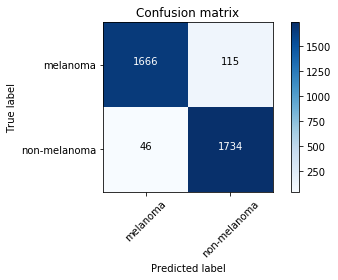

In [5]:
# classes MELANOMA, NON-MELANOMA
test_labels = test_batches.classes

predictions = model.predict_generator(test_batches, steps = val_steps, verbose = 1)

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

print_results(cm)

plot_confusion_matrix(cm, ['melanoma', 'non-melanoma'])